<a href="https://colab.research.google.com/github/vheastman/ChallengerOringFailures/blob/master/SwitchboardDSPractical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Switchboard Data Science Practical

Date: February 5th, 2023

**Prompt 1**: Based on the provided data, what aspects of message sends seem most relevant to engagement? If you were going to provide direct guidance to customers running messaging programs, what would you tell them (if anything)?

**Prompt 2**: Based on your exploration of this data set, what other questions do you have? What would you want to collect more data on (or spend more time with this data) to understand better, and/or what questions would you have for customers, our customer-facing employees, or other folks on the team to help us help our customers run better programs?

Assumptions:
- Based on the data dictionary, I'm assuming the [broadcast_id, organization_id] combination can be used to identify distinct messaging campaigns.
- The `created` column in the actions table corresponds to when the action was taken and can be used to compare to the `sent_time` column in the messages table.

Ideas:
- Message type: sms vs mms
- Send time
- Message length
- How long after send is the action taken?
- Geography (using area codes)


If I had more time:
- Message content 
- Clear CTA
- Personalization
- [not in this data] Audience optimization


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Connect to data in google drive

# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Read in csvs
#https://drive.google.com/file/d/1FOguMSbGk26jlzkc-RMZHCM_4sl0t51F/view?usp=share_link
#https://drive.google.com/file/d/12bgmU-bOCu9xu_TmhA0Pzfk6L4mCRaba/view?usp=share_link

downloaded = drive.CreateFile({'id':'1FOguMSbGk26jlzkc-RMZHCM_4sl0t51F'}) 
downloaded.GetContentFile('actions.csv')  
df_a = pd.read_csv('actions.csv')

downloaded = drive.CreateFile({'id':'12bgmU-bOCu9xu_TmhA0Pzfk6L4mCRaba'}) 
downloaded.GetContentFile('messages.csv')  
df_m = pd.read_csv('messages.csv')

In [ ]:
## Make some adjustments to the dfs

# Convert appropriate columns to timestamps:
for col in ['created', 'modified']:
  df_m[col] = pd.to_datetime(df_m[col])
  df_a[col] = pd.to_datetime(df_a[col])

df_m['sent_time'] = pd.to_datetime(df_m['sent_time'])

In [ ]:
## What size is the data?
print(df_a.shape)
print(df_m.shape)

(733650, 11)
(2783096, 18)


In [ ]:
####### Data Validation
## Which columns are empty?
print("Actions Table:")
for col in df_a.columns:
  print(col + ": " + str(df_a[col].isnull().all(axis=0)))

print()
print("Messages Table:")
for col in df_m.columns:
  print(col + ": " + str(df_m[col].isnull().all(axis=0)))


Actions Table:
id: False
created: False
modified: False
action: False
metadata: True
referrer: True
user_agent: False
query_parameters: True
ip: False
phone_message_id: False
organization_id: False

Messages Table:
id: False
created: False
modified: False
text: False
is_from_contact: False
send_status: False
broadcast_id: False
organization_id: False
phone_contact_id: False
provider: False
provider_message_id: False
provider_messaging_service_sid: False
error_code: True
error_message: True
message_type: False
sent_time: False
from_number: True
to_number: False


In [ ]:
## Drop empty columns to help with memory issues:
for col in df_m.columns:
  if df_m[col].isnull().all(axis=0):
    df_m = df_m.drop(col, axis=1)

In [ ]:
# ## Look at the data
# print("Actions Table:")
# print(df_a.head())

# print("Messages Table:")
# print(df_m.head())

In [ ]:
### Data Validation
## Question: Do all messages with a 'Donation' action also have a 'Click' action?
print(df_a.action.value_counts())
print()
print("Do all messages with a 'Donation' action also have a 'Click' action?")
set(df_a.loc[df_a['action'] == 'DONATION','phone_message_id']).issubset(set(df_a.loc[df_a['action'] == 'CLICK','phone_message_id']))

## Answer: Yes! One message can have both action types

CLICK       520344
DONATION    213306
Name: action, dtype: int64

Do all messages with a 'Donation' action also have a 'Click' action?


True

In [ ]:
## Identify the number and size of each message campaigns
cmpns = pd.DataFrame(df_m.groupby(['broadcast_id', 'organization_id']).size()).reset_index()
cmpns.columns = ['broadcast_id', 'organization_id', 'message_count']
cmpns = cmpns.sort_values(by=['message_count'], ascending=False).reset_index().drop('index', axis=1)

Text(0.5, 1.0, 'Volume of Messages Sent in Each Messaging Campaign')

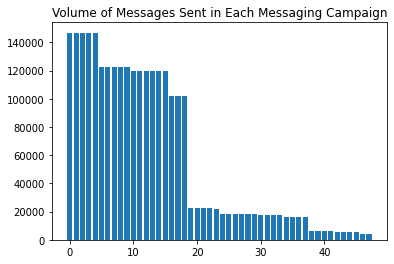

In [ ]:
### Plot the message send size
plt.bar(cmpns.index,cmpns.message_count)
plt.title('Volume of Messages Sent in Each Messaging Campaign')

In [ ]:
## Merge tables to get actions with raw message data
for act in ['CLICK', 'DONATION']:
  df_m = pd.merge(df_m, df_a.loc[df_a['action'] == act,['phone_message_id', 'action', 'created']], how = 'left', left_on='id', right_on='phone_message_id')
  df_m = df_m.rename(columns={'action': act.lower(), "created_y": act.lower() + "_time", "created": act.lower() + "_time"})
  df_m = df_m.drop('phone_message_id', axis=1)

## Turn them into booleans
df_m.loc[df_m['click'] == 'CLICK', 'click'] = 1
df_m.loc[df_m['donation'] == 'DONATION', 'donation'] = 1
df_m['click'] = df_m['click'].fillna(0)
df_m['donation'] = df_m['donation'].fillna(0)

In [ ]:
df_m.head()

,id,created_x,modified,text,is_from_contact,send_status,broadcast_id,organization_id,phone_contact_id,provider,provider_message_id,provider_messaging_service_sid,message_type,sent_time,to_number,click,click_time,donation,donation_time
0,1,2022-10-30 10:38:00-04:00,2022-10-30 10:38:00-04:00,"Hi, it's Battery PAC Nicholas, we've been on t...",False,delivered,42,1,1,BW,22a0c4dd-919c-4946-a933-224bfa2bcca3,117,sms,2022-10-30 10:46:00-04:00,+16074569472,1,2022-10-30 11:05:00-04:00,1,2022-10-30 11:09:00-04:00
1,2,2022-10-30 10:38:00-04:00,2022-10-30 10:38:00-04:00,"Hi, it's Battery PAC Russell, we've been on th...",False,delivered,42,1,2,BW,a3b25eae-1083-4555-b565-242272842159,117,sms,2022-10-30 10:42:00-04:00,+17793633436,1,2022-10-30 11:15:00-04:00,1,2022-10-30 11:21:00-04:00
2,3,2022-10-30 10:38:00-04:00,2022-10-30 10:38:00-04:00,"Hi, it's Battery PAC Zachary, we've been on th...",False,delivered,42,1,3,BW,6ffd174a-0ac2-4fa0-9afc-2bdeeb7ed113,117,sms,2022-10-30 10:41:00-04:00,446-573-6337,0,NaT,0,NaT
3,4,2022-10-30 10:38:00-04:00,2022-10-30 10:38:00-04:00,"Hi, it's Battery PAC Brittany, we've been on t...",False,delivered,42,1,4,BW,6f2560f9-e17d-4ffd-9645-a97c9d5136be,117,sms,2022-10-30 10:44:00-04:00,535-645-4046,0,NaT,0,NaT
4,5,2022-10-30 10:38:00-04:00,2022-10-30 10:38:00-04:00,"Hi, it's Battery PAC Elijah, we've been on thi...",False,delivered,42,1,5,BW,69ba1e19-8928-4a54-b09e-d329e9acaa5d,117,sms,2022-10-30 10:39:00-04:00,+14069592536,0,NaT,0,NaT


In [ ]:
## Check some assumptions
# Does the action table `created` column capture the timestamp of when the action was taken?
print("Is the action table's 'created' timestamp always later than the 'sent_time' timestamp?")
print()
print("CLICKS:")
dfc = df_m.loc[df_m.click == 1]
print((dfc['sent_time'] < dfc['click_time']).value_counts())
print(str(round(((dfc['sent_time'] < dfc['click_time']).value_counts()[0] / dfc.shape[0])*100,2)) + "% of messages have a negative time delta between when they were sent and when the click action was taken.")

print()
print("DONATIONS:")
dfd = df_m.loc[df_m.donation == 1]
print((dfd['sent_time'] < dfd['donation_time']).value_counts())
print(str(round(((dfd['sent_time'] < dfd['donation_time']).value_counts()[0] / dfd.shape[0])*100,2)) + "% of messages have a negative time delta between when they were sent and when the click action was taken.")

Is the action table's 'created' timestamp always later than the 'sent_time' timestamp?

CLICKS:
True     484080
False     36264
dtype: int64
6.97% of messages have a negative time delta between when they were sent and when the click action was taken.

DONATIONS:
True     192351
False     20955
dtype: int64
9.82% of messages have a negative time delta between when they were sent and when the click action was taken.


#### Success by Campaign

In [ ]:
## Identify the number and size of each message campaigns
cmpns = pd.DataFrame(df_m.groupby(['broadcast_id', 'organization_id']).size()).reset_index()
cmpns.columns = ['broadcast_id', 'organization_id', 'message_count']
cmpns = cmpns.sort_values(by=['message_count'], ascending=False).reset_index().drop('index', axis=1)

Text(0.5, 1.0, 'Volume of Messages Sent in Each Messaging Campaign')

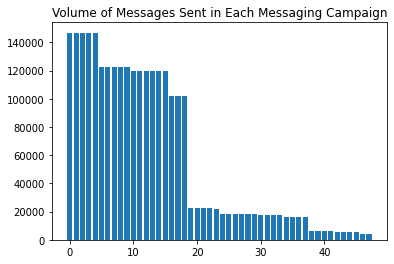

In [ ]:
### Plot the message send size
plt.bar(cmpns.index,cmpns.message_count)
plt.title('Volume of Messages Sent in Each Messaging Campaign')

In [ ]:
## Calculate click and donation rates for each campaign
for col in ['click', 'donation']:
  df_ = pd.DataFrame(df_m.groupby(['broadcast_id', 'organization_id']).apply(lambda x: (x[x[col] == 1].shape[0] / x.shape[0])) * 100).reset_index()
  df_.columns = ['broadcast_id', 'organization_id', col + '_rate']
  cmpns = pd.merge(cmpns, df_, how = 'left', left_on=['broadcast_id', 'organization_id'], right_on=['broadcast_id', 'organization_id'])

Text(0.5, 1.0, 'Click Rate vs Message Count')

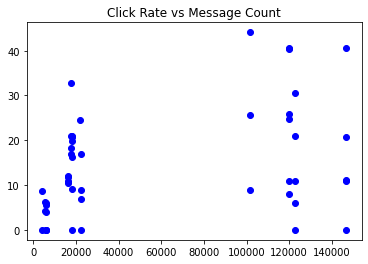

In [ ]:
plt.plot(cmpns.message_count,cmpns.click_rate, 'bo')
plt.title("Click Rate vs Message Count")

Text(0.5, 1.0, 'Donation Rate vs Message Count')

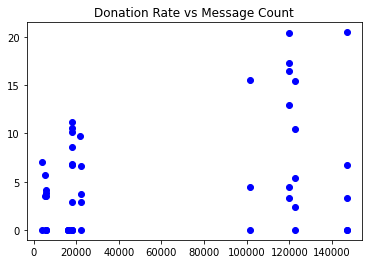

In [ ]:
plt.plot(cmpns.message_count,cmpns.donation_rate, 'bo')
plt.title("Donation Rate vs Message Count")

## Create Features 

Outcomes:
*   Click
*   Donation

Inputs: 
*   Time of day (int): hour of the day extracted from `sent_time`
*   Organization (boolean): Dummy variables created from `organization_id` column
*   Broadcast (boolean): Dummy variables created from `broadcast_id` column
*   Message Type (boolean): Dummy variable created from `message_type` column
*   Click time since send (timedelta): timedelta from `sent_time` to `click_time`
*   Donation time since send (timedelta): timedelta from `sent_time` to `donation_time`
*   Personalization (boolean): Dummy variable created from `text` column if there's a first name in the text of the message.  


In [ ]:
## Only keep necessary columns
df = df_m[['click', 'donation', 'sent_time', 'organization_id', 'broadcast_id', 'message_type', 'click_time', 'donation_time', 'text']]

In [ ]:
## Extract hour of day from `sent_time`
df['hour_of_day'] = [i.hour for i in df['sent_time']]

In [ ]:
## Create org_id dummy variables
df['organization_id'] = ['org_' + str(i) for i in df['organization_id']]
df = df.join(df['organization_id'].astype(str).str.get_dummies())

In [ ]:
## Create broadcast_id dummy variables
df['broadcast_id'] = ['msg_' + str(i) for i in df['broadcast_id']]
df = df.join(df['broadcast_id'].astype(str).str.get_dummies())

In [ ]:
## Create message type dummy variables
df = df.join(df['message_type'].astype(str).str.get_dummies())

In [ ]:
df.head()